In [78]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from pathlib import Path
from torchvision.models import vgg16_bn

In [79]:
path = Path('/home/ec2-user/SageMaker/video_upscaling')
path_data = path/'data'/'DIV2K_train_HR'
path_lr = path/'data'/'lr'
path_mr = path/'data'/'mr'

In [80]:
il = (ImageList.from_folder(path_data)
     #       .use_partial_data(sample_pct=.05, seed=42)
     )

In [81]:
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_data)
    dest.parent.mkdir(parents=True, exist_ok=True)
    
    img = PIL.Image.open(fn)
    targ_size = resize_to(img, size, use_min=True)
    img = img.resize(targ_size, resample=PIL.Image.BILINEAR).convert('RGB')
    
    img.save(dest, quality=60)

In [82]:
sets = [(path_lr, 96), (path_mr, 256)]

for p, size in sets:
    if not p.exists():
        parallel(partial(resize_one, path=p, size=size), il.items)

In [83]:
bs, size = 32, 128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [84]:
def get_data(bs, size):
    data = (src.label_from_func(lambda x: path_data/x.name)
               .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
               .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    
    data.c = 3
    return data

In [85]:
data = get_data(bs, size)

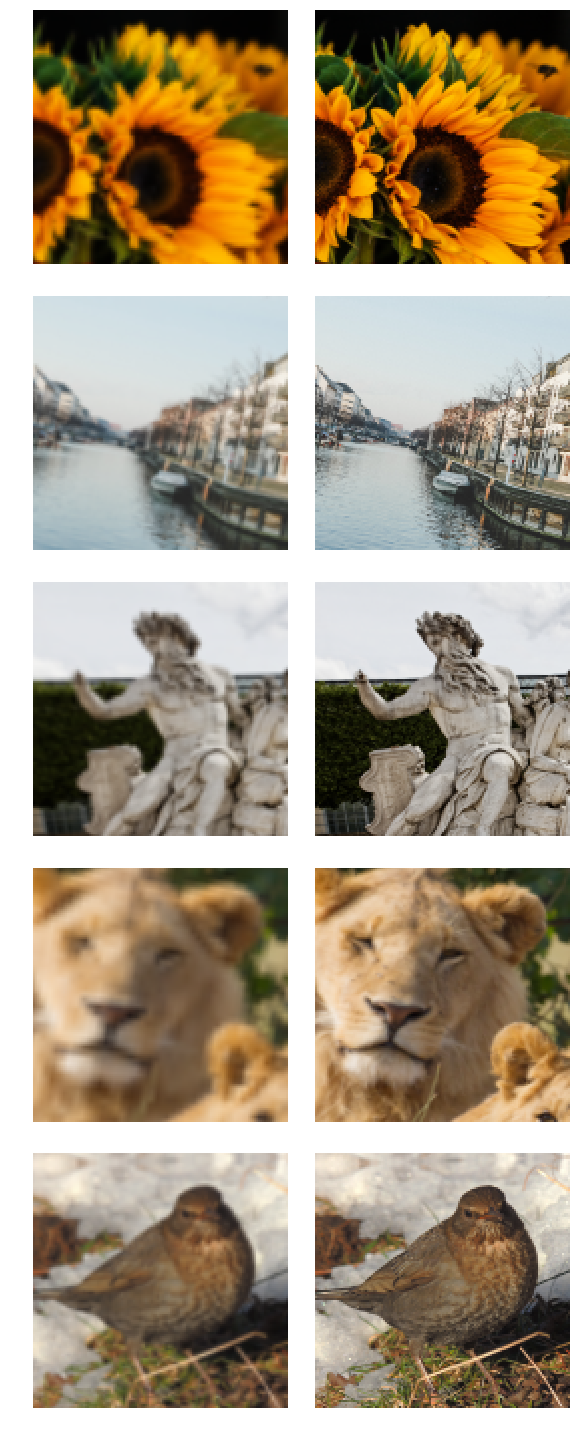

In [87]:
data.show_batch()

## Feature loss

In [88]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [89]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [90]:
base_loss = F.l1_loss

In [91]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [92]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [93]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [94]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [95]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

In [96]:
#learn.lr_find()
#learn.recorder.plot()

In [97]:
lr = 1e-3

In [98]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,4.596178,3.668550,0.276448,0.253876,0.348621,0.168001,0.792163,1.358116,0.471325,01:17
1,3.766748,2.920196,0.214432,0.201868,0.275163,0.139399,0.605087,1.070821,0.413426,00:55
2,3.249282,2.500553,0.197261,0.179124,0.235518,0.125077,0.503896,0.880189,0.379487,00:55
3,2.933806,2.355482,0.200498,0.171125,0.222870,0.119336,0.450440,0.826143,0.365070,00:55
4,2.769650,2.293439,0.196845,0.167172,0.217792,0.114954,0.438422,0.805834,0.352421,00:55
5,2.703159,2.341886,0.197416,0.168506,0.219826,0.117567,0.464960,0.813354,0.360256,00:55
6,2.673723,2.407263,0.194539,0.166702,0.222583,0.120547,0.490122,0.842223,0.370548,00:56
7,2.617389,2.377745,0.201690,0.164497,0.218819,0.117287,0.476298,0.841174,0.357981,00:56
8,2.582962,2.314349,0.208332,0.157932,0.211495,0.113342,0.450983,0.828339,0.343926,00:56
9,2.515607,2.140395,0.179929,0.152156,0.200439,0.109189,0.416766,0.746347,0.335568,00:56


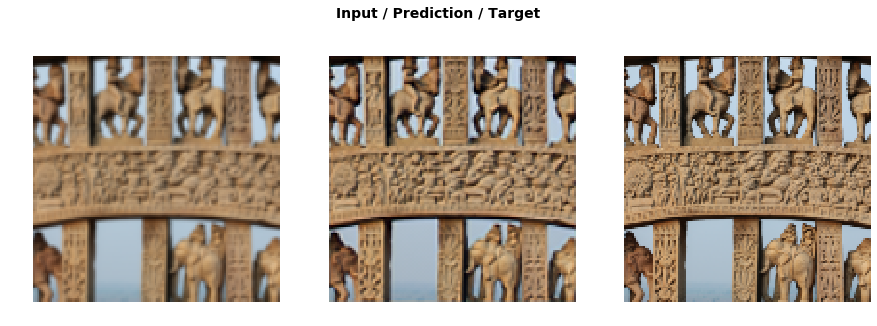

In [99]:
do_fit('1a', slice(lr*10))

In [100]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.321765,2.081373,0.167243,0.149952,0.197081,0.107903,0.406935,0.718707,0.333552,00:55
1,2.307492,2.063206,0.165078,0.148912,0.195362,0.107494,0.404703,0.708394,0.333262,00:56
2,2.288123,2.045583,0.165045,0.148171,0.194026,0.106431,0.400663,0.700986,0.330260,00:55
3,2.285843,2.038822,0.164964,0.148125,0.193622,0.105993,0.395749,0.701566,0.328803,00:56
4,2.273288,2.021490,0.163894,0.147516,0.192120,0.105610,0.391640,0.691357,0.329352,00:55
5,2.262766,2.015687,0.165437,0.147461,0.191645,0.105199,0.387436,0.689698,0.328812,00:56
6,2.239350,1.983572,0.165304,0.146477,0.189811,0.104208,0.372913,0.679245,0.325614,00:55
7,2.230782,1.968554,0.165637,0.145583,0.188329,0.102982,0.369119,0.676243,0.320661,00:55
8,2.215113,1.960633,0.163823,0.145718,0.188636,0.102366,0.363983,0.677240,0.318867,00:56
9,2.202544,1.933506,0.163122,0.144432,0.186223,0.101630,0.359726,0.659938,0.318434,00:55


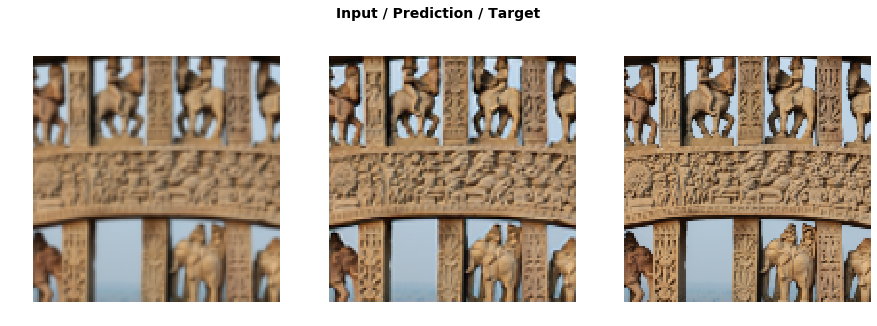

In [101]:
do_fit('1b', slice(1e-5,lr))

## Test

In [102]:
learn = None
gc.collect();

In [104]:
size=(128,128)

In [105]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)

In [106]:
data_lr = (ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_data/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_lr.c = 3

In [107]:
learn.load('1b');

In [109]:
learn.data = data_lr

In [111]:
fn = data_lr.valid_ds.x.items[0]; fn

PosixPath('/home/ec2-user/SageMaker/video_upscaling/data/lr/0482.png')

In [112]:
img = open_image(fn); img.shape

torch.Size([3, 96, 131])

In [113]:
p,img_hr,b = learn.predict(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


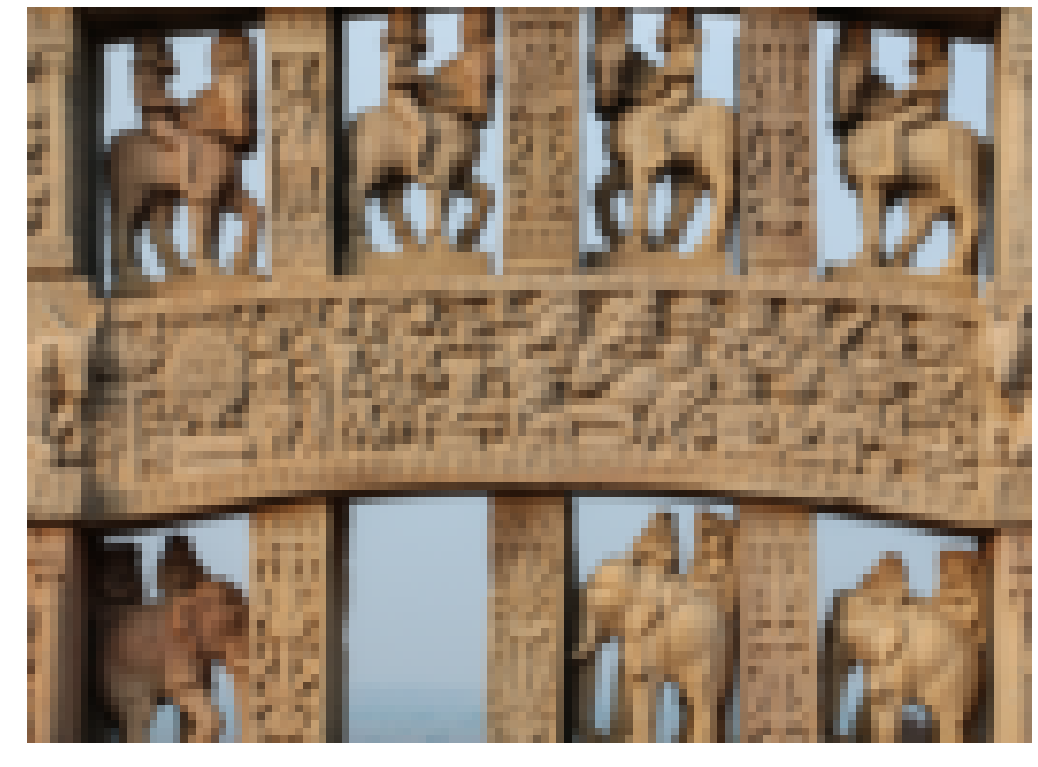

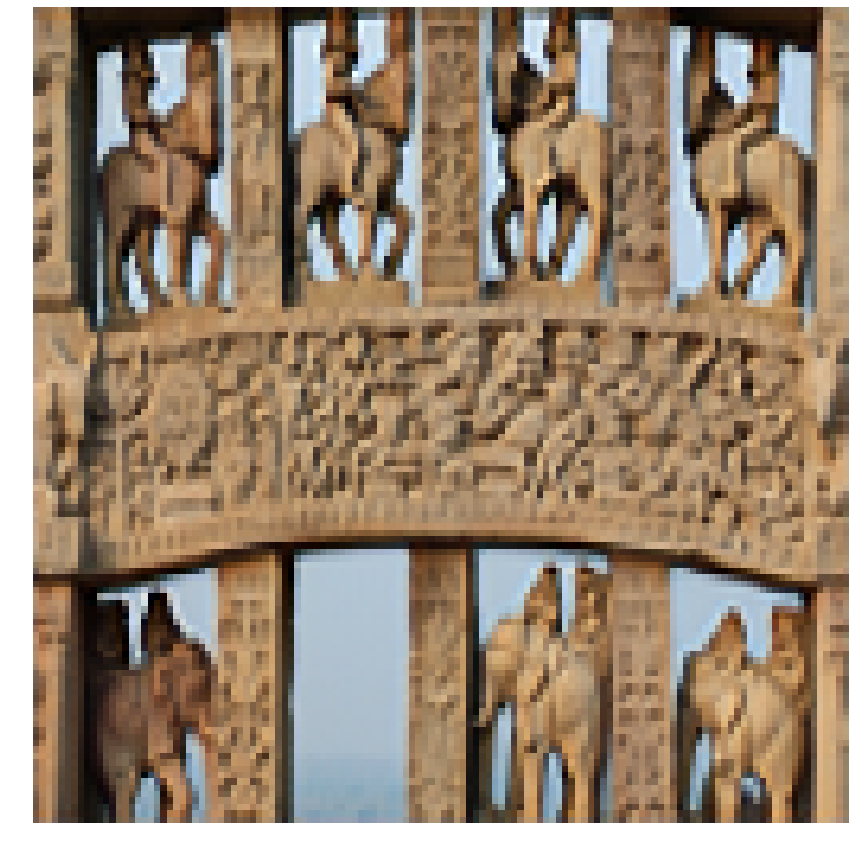

In [116]:
show_image(img, figsize=(9,6), interpolation='nearest');
Image(img_hr).show(figsize=(9,15))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


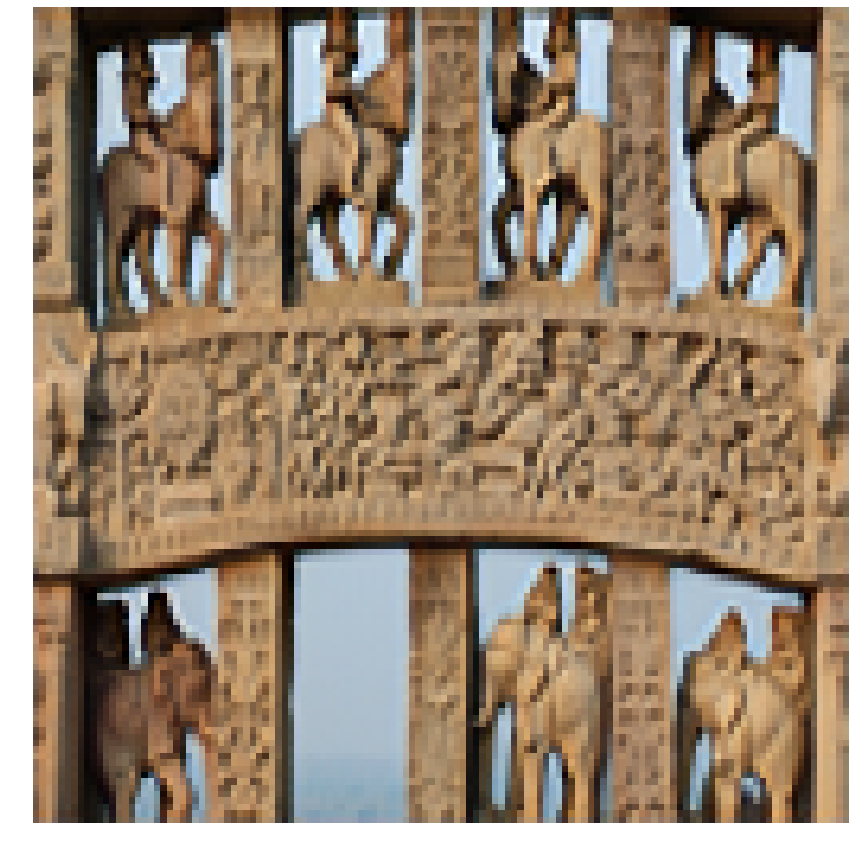

In [115]:
Image(img_hr).show(figsize=(18,15))